In [1]:
import lsdtopytools as lsd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import lsdttparamselector as ps
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw
import lsdttparamselector as ps
import rasterio
from osgeo import gdal
%matplotlib inline

In [2]:
DataDirectory = "./"
RasterFile = "tile_20.tif"
position=RasterFile.index('.')
filename=RasterFile[0:position]
gio.convert4lsdtt(DataDirectory, RasterFile,minimum_elevation=0.01,resolution=3)

The projections is:
PROJCS["NAD83 / UTM zone 18N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26918"]]
And some extra projection information strings:
NAD83 / UTM zone 18N
NAD83
The centre of the raster is at:
(216061.0604597426, 4489018.512502102)
dem_data.width is: 3561
The centre lat-long is
40.50331467810073 -78.35081365186205
res tuple is:
(3, 3)
The destination CRS is: EPSG:32617


/home/jmdelvecchio/miniconda3/envs/lsdtopytools/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/jmdelvecchio/miniconda3/envs/lsdtopytools/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 3695, 'height': 3614, 'count': 1, 'crs': CRS.from_epsg(32617), 'transform': Affine(3.0, 0.0, 719055.8332164849,
       0.0, -3.0, 4492553.59129114)}
Removing pixels with an elevation less than 0.01


'tile_20_UTM.tif'

In [3]:
lsdtt_parameters = {"surface_fitting_radius" : "3",
                    "print_slope" : "true",
                    "print_curvature" : "true",
                    "print_dinf_drainage_area_raster": "true"}
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = filename + "_UTM",
                                 write_prefix= filename + "_UTM",
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()


The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: tile_20_UTM
The write prefix is: tile_20_UTM
The parameter dictionary is:
{'surface_fitting_radius': '3', 'print_slope': 'true', 'print_curvature': 'true', 'print_dinf_drainage_area_raster': 'true'}


In [4]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


In [5]:
filename + '_SLOPE.tif'

'tile_20_SLOPE.tif'

In [6]:
kwargs = {
    'format': 'GTiff',
    'outputType': gdal.GDT_Float32
}
#    'outputType': gdal.GDT_Int16

_ = gdal.Translate(filename + '_SLOPE.tif',filename + '_UTM_SLOPE.bil',**kwargs)
_ = gdal.Translate(filename + '_CURV.tif',filename + '_UTM_CURV.bil',**kwargs)
_ = gdal.Translate(filename + '_dinf_area.tif',filename + '_UTM_dinf_area.bil',**kwargs)
# ds = None

In [7]:
import fiona
import rasterio
import rasterio.mask

darea = rasterio.open(filename + '_dinf_area.tif')
curve = rasterio.open(filename + '_CURV.tif')
slope = rasterio.open(filename + '_SLOPE.tif')
elev = rasterio.open(filename + '.tif')
msk_d = darea.read_masks()
darea_data = darea.read(1, masked=True)
curve_data = curve.read(1, masked=True)
slope_data = slope.read(1, masked=True)
darea_array=darea_data.flatten()
curve_array=curve_data.flatten()
slope_array=slope_data.flatten()

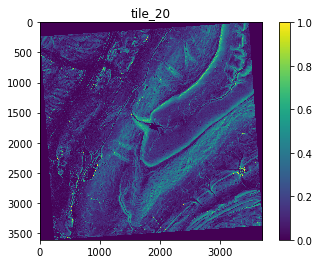

In [8]:
plt.imshow(slope.read(1), vmin=0, vmax=1)
plt.colorbar()
plt.title(filename)
plt.savefig(filename + '_slope.png')

In [23]:
#Bin edges go by 10 until 1000 m^2
a1=10.**(np.arange(3, 7)) 
a2 = np.arange(1,10,1)
a3 = np.arange(0,1000,10)
bin_edges = np.append(a3, (np.outer(a1, a2).flatten()))


(10.0, 1000000.0)

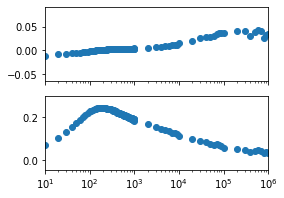

In [24]:
from scipy.stats import binned_statistic

med_stat_ca = binned_statistic(darea_array,curve_array,
                            statistic='median',
                            bins=bin_edges)

med_stat_sa = binned_statistic(darea_array,slope_array,
                            statistic='median',
                            bins=bin_edges)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,3), sharex=True)
ax1.scatter(med_stat_ca.bin_edges[:-1],med_stat_ca.statistic)
ax2.scatter(med_stat_sa.bin_edges[:-1],med_stat_sa.statistic)
ax1.set_xscale('log')
ax1.set_xlim(1e1, 1e6)

In [9]:
with fiona.open("Tuscarora.shp", "r") as shapefile:
    Tuscarora_mask = [feature["geometry"] for feature in shapefile]

In [10]:
out_image, out_transform = rasterio.mask.mask(slope, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

ValueError: Input shapes do not overlap raster.

In [46]:
slope_tusc, out_transform = rasterio.mask.mask(slope, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

from rasterio.plot import show
show(slope_tusc)

ValueError: Input shapes do not overlap raster.

In [9]:


slope_tusc, out_transform = rasterio.mask.mask(slope, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

curve_tusc, out_transform = rasterio.mask.mask(curve, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
darea_tusc, out_transform = rasterio.mask.mask(darea, Tuscarora_mask, crop=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

darea_t_array=darea_tusc.flatten()
curve_t_array=curve_tusc.flatten()
slope_t_array=slope_tusc.flatten()

med_stat_t_ca = binned_statistic(darea_t_array,curve_t_array,
                            statistic='median',
                            bins=bin_edges)

med_stat_t_sa = binned_statistic(darea_t_array,slope_t_array,
                            statistic='median',
                            bins=bin_edges)


ValueError: Input shapes do not overlap raster.

In [15]:
slope_ntusc, out_transform = rasterio.mask.mask(slope, Tuscarora_mask, invert=True)
out_meta = slope.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})

curve_ntusc, out_transform = rasterio.mask.mask(curve, Tuscarora_mask, invert=True)
out_meta = curve.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
darea_ntusc, out_transform = rasterio.mask.mask(darea, Tuscarora_mask, invert=True)
out_meta = darea.meta
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
# with rasterio.open("Tusc_masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)
darea_nt_array=darea_ntusc.flatten()
curve_nt_array=curve_ntusc.flatten()
slope_nt_array=slope_ntusc.flatten()
med_stat_nt_ca = binned_statistic(darea_nt_array,curve_nt_array,
                            statistic='median',
                            bins=bin_edges)

med_stat_nt_sa = binned_statistic(darea_nt_array,slope_nt_array,
                            statistic='median',
                            bins=bin_edges)

/home/jmdelvecchio/miniconda3/envs/lsdtopytools/lib/python3.7/site-packages/rasterio/mask.py:92: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


NameError: name 'out_image' is not defined

In [21]:
max_slope_t = max(med_stat_t_sa.statistic.tolist())
max_slope_da_t = med_stat_t_sa.bin_edges[med_stat_t_sa.statistic.tolist().index(max_slope_t)]
print(max_slope_da_t)
max_slope_nt = max(med_stat_nt_sa.statistic.tolist())
max_slope_da_nt = med_stat_nt_sa.bin_edges[med_stat_nt_sa.statistic.tolist().index(max_slope_nt)]
print(max_slope_da_nt)

410.0
180.0


In [22]:
import pandas as pd

In [23]:


df = pd.DataFrame(list(zip(bin_edges[1:],med_stat_sa.statistic.tolist(),med_stat_ca.statistic.tolist(),
                        med_stat_t_sa.statistic.tolist(),med_stat_t_ca.statistic.tolist(),
                        med_stat_nt_sa.statistic.tolist(),med_stat_nt_ca.statistic.tolist())),
               columns = ['Bin', 'Slp_all', 'Curv_all', 'Slp_tusc', 'Curv_tusc', 'Slp_ntsc', 'Curv_ntusc'])

ds = gdal.Open(RasterFile)
df['topleftx'] = np.array(ds.GetGeoTransform()[0], dtype=np.float32)
df['toplefty']  = np.array(ds.GetGeoTransform()[3], dtype=np.float32)
df['ref']  = ds.GetProjection()[0:45]


df.to_csv(filename + '_stats.csv',columns=df.columns, index=False)

In [ ]:
df['topleftx']=tlx

In [ ]:
df

In [31]:
import os
for file in os.listdir("."):
    if file.endswith(".bil"):
        os.remove((os.path.join(".", file)))
    if file.endswith(".hdr"):
        os.remove((os.path.join(".", file)))

./hunt_UTM.hdr
./hunt_UTM_CURV.hdr
./hunt_UTM_dinf_area.hdr
./hunt_UTM_SLOPE.hdr


In [ ]:
ds = gdal.Open("hunt.tif")
tl = (ds.GetGeoTransform()[0],ds.GetGeoTransform()[3])
ref = ds.GetProjection()[0:45]

In [ ]:
ds.GetGeoTransform()

In [ ]:
ds.GetProjection()[0:45]

In [ ]:
mydem = lsd.LSDDEM(path = "./", file_name = "hunt.tif", already_preprocessed = False)
mydem.PreProcessing()

In [ ]:
mydem.CommonFlowRoutines()

In [ ]:
mydem.get_polyfit_metrics(slope=False,TSP=True)

In [ ]:
help(lsd.LSDDEM)

In [ ]:
TSP = rasterio.open('./hunt/TSP_30.tif')
plt.imshow(TSP.read(1), vmin=0)
plt.colorbar()